In [1]:
import sys
import matplotlib.pyplot as plt

from contextualbandits import online as cb
from copy import deepcopy as clone
import numpy as np
import pandas as pd
# The only classifiers that have partial_fit
# See: https://scikit-learn.org/0.15/modules/scaling_strategies.html
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
sys.path.append("../src")

%matplotlib inline

In [2]:
from wrappers import decision_function_from_proba

# Read data & preprocess

In [3]:
def keep_values_by_min_freq(df, col, freq=0.9,other="OTHER"):
    ds = df[col].value_counts(normalize=True).cumsum()<freq
    values = set(ds[ds].index)
    df.loc[~(df[col].isin(values)), col]=other
    return df
def preprocess(df):
    df = df.drop("sessionId", axis=1)
    df["ts"] = pd.to_datetime(df["ts"]*1000000)
    df["day_of_week"]=df["ts"].dt.weekday.astype("category")
    df["time_of_day"]=df["ts"].dt.hour.astype("category")
    df = df.drop("ts", axis=1)
    df = keep_values_by_min_freq(df, "networkId")
    a = df["bidPrice"].round(2)
    r = df["hasWon"]
    df = df.drop(["bidPrice", "hasWon"],axis=1)    
    X = pd.get_dummies(df)
    return X,a, r
df = pd.read_csv("../data/data.csv")
# sample
df = df.query("placementType=='banner' and bidPrice<1.01").drop("placementType",axis=1)
X, a, r = preprocess(df)
X

,networkId_59,networkId_108,networkId_115,networkId_172,networkId_194,networkId_235,networkId_254,networkId_278,networkId_307,networkId_322,...,time_of_day_14,time_of_day_15,time_of_day_16,time_of_day_17,time_of_day_18,time_of_day_19,time_of_day_20,time_of_day_21,time_of_day_22,time_of_day_23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607672,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Contextual bandits

In [4]:
bids = sorted(set(a))
n_arms = len(bids)
base_model = SGDClassifier(loss='log')
desired_win_rate=0.1
@decision_function_from_proba(base_model)
def normalize_proba(proba):
    return np.abs(-desired_win_rate)
logreg_ts = cb.BootstrappedTS(clone(base_model), n_arms, batch_train=True)
logreg_ucb = cb.BootstrappedUCB(clone(base_model), n_arms, batch_train=True)
logreg_eg = cb.EpsilonGreedy(clone(base_model), n_arms, batch_train=True)
#logreg_ts.partial_fit(X,a,r)

In [5]:

def simulate(model, X, a , r, chunk = 100, limit=10000):
    X,a,r=map(clone,[X,a,r])
    train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
    X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
    test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
    n_iterations = 1
    diffs = []
    while len(X)>chunk:
        model.partial_fit(train_X,train_a,train_r)
        pred_bids = model.predict(test_X)
        #TODO: Verify order
        diffs.append(np.sum([np.abs(bids[i]-y) for i,y in zip(pred_bids,test_r.values)])/chunk)
        train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
        test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        n_iterations+=1
        if limit>0 and limit<n_iterations:
            break
    return diffs

# plot

Text(0.5, 0, 'iterations')

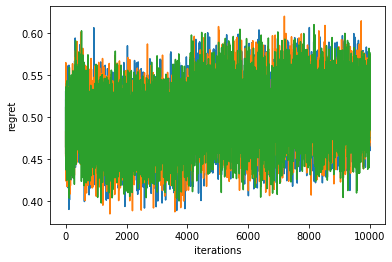

In [6]:
regret = simulate(logreg_ts, X,a,r)
plt.plot(np.arange(len(regret)), regret)
regret = simulate(logreg_ucb, X,a,r)
plt.plot(np.arange(len(regret)), regret)
regret = simulate(logreg_eg, X,a,r)
plt.plot(np.arange(len(regret)), regret)
plt.ylabel("regret")
plt.xlabel("iterations")